In [1]:
import os
import random
import _pickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from tensorflow.keras import utils as image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm
import collections


# Grab the Image Data

In [2]:
images_path = 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\images\\'
max_num_images = 100000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 85880 images to analyze


In [3]:
len(images)

85880

## get_image will return a handle to the image itself, and a numpy array of its pixels to input the network


In [3]:
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Below are testing methods needed for different tests

In [4]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [5]:
def test_single_image_accuracy(test_image_index, top_closest_idx_to_return = 10, plot = False):
    query_image_idx = test_image_index
    idx_closest = get_closest_images(query_image_idx, top_closest_idx_to_return)
    query_image = get_concatenated_images([query_image_idx], 300)
    results_image = get_concatenated_images(idx_closest, 200)

    query_true_label = images[test_image_index].split("\\")[-2]

    predicted_labels_of_indexes = []
    for id in idx_closest:
        if images[id].split("\\")[-2] == query_true_label:
            predicted_labels_of_indexes.append(True)
        else:
            predicted_labels_of_indexes.append(False)
    
    total_true_label = sum(predicted_labels_of_indexes)
    
    if plot:
        # display the query image
        matplotlib.pyplot.figure(figsize = (5,5))
        imshow(query_image)
        matplotlib.pyplot.title("query image (%d)" % query_image_idx)

        # display the resulting images
        matplotlib.pyplot.figure(figsize = (16,12))
        imshow(results_image)
        matplotlib.pyplot.title("result images")


    return query_image, results_image, idx_closest, predicted_labels_of_indexes, round(total_true_label / len(predicted_labels_of_indexes), 3) * 100

In [6]:
def test_all_image_accuracy(test_split_set_of_images, top_closest_idx_to_return = 3):
    test_results = []
    for idx, tst_img in tqdm(enumerate(test_split_set_of_images)):
        
        query_image, results_image, idx_closest, predicted_labels_of_indexes, precent_correct = test_single_image_accuracy(idx, top_closest_idx_to_return)
        row = [query_image, results_image, idx_closest, predicted_labels_of_indexes, precent_correct]
        test_results.append(row)

    return  test_results



## Find recipes of top N closest images that we found

### Read the recipe csv which holds the labels and it's corresponding recipes

In [21]:
import pandas as pd

In [22]:
recipes = pd.read_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\recipe_name_image_lookup.csv")

In [44]:
def get_recomended_recipes_for_closest_image(single_test_result):
    idx_closest = single_test_result[-3]
    pred_labels = []
    recomended_recipies = pd.DataFrame(columns= ["Categories","ingredients", "instructions"])
    for id in idx_closest:
        pred_label = images[id].split("\\")[-2] # grabbing the label for the image, S.O to Shruti for this hack
        pred_labels.append(pred_label)
    pred_labels = list(set(pred_labels))

    for label in pred_labels:
        temp = recipes[recipes.directories_names == label][["directories_names","ingredients", "instructions"]].sample(n = 1)
        temp.rename(columns = {'directories_names':'Categories'}, inplace = True)

        recomended_recipies = pd.concat([recomended_recipies, temp])
        
    return recomended_recipies
        
        

# With FC2

### with 90-10 Split

### Train test split

In [8]:
percent_split = 0.10

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
images_train_percent, images_test_percent =  train_test_split(images, test_size =percent_split, shuffle  = False)

### Call the base imagenet model with VGG16


In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
# model.summary()

## Doing this with last-to-second layer - Needed

In [18]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output) # change around with fc1
# feat_extractor.summary()

## DO NOT RUN BELOW YOU WILL BREAK YOUR LAPTOP, read the pickle instead if available

## Creating features off of the trainining images with their corresponding topics

In [19]:
features = []
count = 1
for image_path in tqdm(images_train_percent):
#     if count %1000 == 0:
#         print("{} im".format(count))
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x, verbose=0)[0]
    features.append(feat)
    count += 1

100%|██████████| 77292/77292 [1:02:55<00:00, 20.47it/s]


In [20]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc2', 'wb') as fp:
        pickle.dump(features, fp)
        print('Done writing list into a binary file')

Done writing list into a binary file


In [10]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc2', 'rb') as fp:
        features = pickle.load(fp)

## PCA

In [11]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

### Testing the code for 10 % test data

In [22]:
test_data_results = test_all_image_accuracy(images_test_percent, 5)

### Create a df from the test_data_results

In [24]:
import pandas as pd
evaluation_df = pd.DataFrame(test_data_results, columns = ['query_image', 'results_image', 'idx_closest', 'predicted_labels_of_indexes', 'precent_correct'])

In [25]:
evaluation_df.to_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\fc2_vgg_090_evaluated_data.csv")

# With 60-40 split

### Train test split

In [29]:
percent_split = 0.40

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
images_train_percent, images_test_percent =  train_test_split(images, test_size =percent_split, shuffle  = False)

### Call the base imagenet model with VGG16


In [31]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
# model.summary()

## Doing this with last-to-second layer - Needed

In [32]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output) # change around with fc1
# feat_extractor.summary()

## DO NOT RUN BELOW YOU WILL BREAK YOUR LAPTOP, read the pickle instead if available

## Creating features off of the trainining images with their corresponding topics

In [20]:
features = []
count = 1
for image_path in tqdm(images_train_percent):
#     if count %1000 == 0:
#         print("{} im".format(count))
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x, verbose=0)[0]
    features.append(feat)
    count += 1

  0%|          | 291/68704 [00:21<1:23:58, 13.58it/s]


KeyboardInterrupt: 

In [ ]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc2_60_40', 'wb') as fp:
        pickle.dump(features, fp)
        print('Done writing list into a binary file')

In [33]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc2_60_40', 'rb') as fp:
        features = pickle.load(fp)

## PCA

In [34]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

### Testing the code for 40 % test data

In [36]:
test_data_results = test_all_image_accuracy(images_test_percent, 5)

34352it [3:14:14,  2.95it/s]


### Create a df from the test_data_results

In [38]:
import pandas as pd
evaluation_df = pd.DataFrame(test_data_results, columns = ['query_image', 'results_image', 'idx_closest', 'predicted_labels_of_indexes', 'precent_correct'])

In [39]:
evaluation_df.to_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\fc2_vgg_6040_evaluated_data.csv")

# With Fc1

## With 90-10 Split

### Train test split

In [8]:
percent_split = 0.10

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
images_train_percent, images_test_percent =  train_test_split(images, test_size =percent_split, shuffle  = False)

### Call the base imagenet model with VGG16


In [10]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
# model.summary()

## Doing this with last-to-second layer - Needed

In [11]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc1").output) # change around with fc1
# feat_extractor.summary()

## DO NOT RUN BELOW YOU WILL BREAK YOUR LAPTOP, read the pickle instead if available

## Creating features off of the trainining images with their corresponding topics

In [12]:
features = []
count = 1
for image_path in tqdm(images_train_percent):
#     if count %1000 == 0:
#         print("{} im".format(count))
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x, verbose=0)[0]
    features.append(feat)
    count += 1

100%|██████████████████████████████████████████████████████████████████████████| 77292/77292 [1:37:31<00:00, 13.21it/s]


In [13]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc1_90_10', 'wb') as fp:
        pickle.dump(features, fp)
        print('Done writing list into a binary file')

Done writing list into a binary file


In [13]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc1_90_10', 'rb') as fp:
        features = pickle.load(fp)

## PCA

In [14]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

### Testing the code for 10 % test data

In [15]:
test_data_results = test_all_image_accuracy(images_test_percent, 5)

8588it [1:07:43,  2.11it/s]


### Create a df from the test_data_results

In [16]:
import pandas as pd
evaluation_df = pd.DataFrame(test_data_results, columns = ['query_image', 'results_image', 'idx_closest', 'predicted_labels_of_indexes', 'precent_correct'])

In [17]:
evaluation_df.to_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\fc1_vgg_9010_evaluated_data.csv")

### End Fc1 90-10 split

## With 60-40 Split

### Train test split

In [9]:
percent_split = 0.40

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
images_train_percent, images_test_percent =  train_test_split(images, test_size =percent_split, shuffle  = False)

### Call the base imagenet model with VGG16


In [11]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
# model.summary()

## Doing this with last-to-second layer - Needed

In [12]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc1").output) # change around with fc1
# feat_extractor.summary()

## DO NOT RUN BELOW YOU WILL BREAK YOUR LAPTOP, read the pickle instead if available

## Creating features off of the trainining images with their corresponding topics

In [13]:
features = []
count = 1
for image_path in tqdm(images_train_percent):
#     if count %1000 == 0:
#         print("{} im".format(count))
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x, verbose=0)[0]
    features.append(feat)
    count += 1

100%|████████████████████████████████████████████████████████████████████████████| 51528/51528 [42:16<00:00, 20.31it/s]


In [14]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc1_60_40', 'wb') as fp:
        pickle.dump(features, fp)
        print('Done writing list into a binary file')

Done writing list into a binary file


In [11]:
import pickle
with open('C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\feature_pickle_vgg_fc1_60_40', 'rb') as fp:
        features = pickle.load(fp)

## PCA

In [12]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

### Testing the code for 40 % test data

In [13]:
test_data_results = test_all_image_accuracy(images_test_percent, 5)

34352it [3:11:48,  2.98it/s]


### Create a df from the test_data_results

In [14]:
import pandas as pd
evaluation_df = pd.DataFrame(test_data_results, columns = ['query_image', 'results_image', 'idx_closest', 'predicted_labels_of_indexes', 'precent_correct'])

In [15]:
evaluation_df.to_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\fc1_vgg_6040_evaluated_data.csv")

# EDA - DO NOT SCROLL

### Test out a sample predicted image - just for EDA

1/1 [==============================] - 2s 2s/step
predicted cheeseburger with probability 0.835
predicted bagel with probability 0.124
predicted meat_loaf with probability 0.014
predicted plate with probability 0.008
predicted bakery with probability 0.006


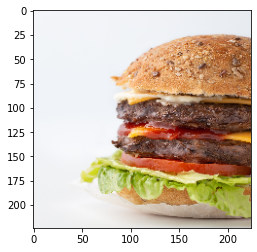

In [ ]:
img, x = get_image("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\food_image_test\\burger\\burger-1.jpg")
predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

### Not Needed EDA Only

1/1 [==============================] - 0s 99ms/step


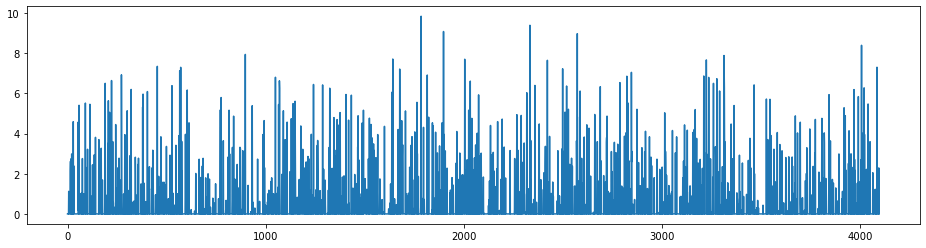

In [ ]:
img, x = get_image("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\food_image_test\\burger\\burger-1.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

Text(0.5, 1.0, 'result images')

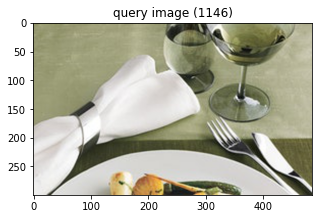

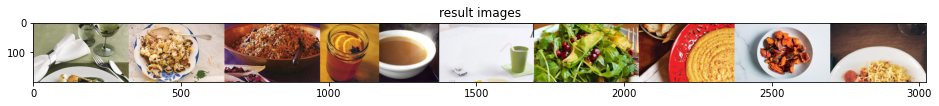

In [ ]:
# do a query on a random image
top_closest_image_to_return = 10
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx, top_closest_image_to_return)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

In [ ]:
images[idx_closest[1]].split("\\")[8]

'roasted_chicken'

## t-SNE Visualizing

In [ ]:
num_images_to_plot = 10

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [ ]:
import json
import matplotlib.pyplot
from PIL import Image
from sklearn.manifold import TSNE

X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

E:\anaconda\envs\food\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 39.3429070, gradient norm = 0.5564865 (50 iterations in 0.013s)
[t-SNE] Iteration 100: error = 35.7412491, gradient norm = 0.5198522 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 54.5900002, gradient norm = 0.1330515 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 64.0930862, gradient norm = 0.3948456 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 39.2117081, gradient norm = 0.5508725 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.211708
[t-SNE] Iteration 300: error = 0.2641012, gradient norm = 0.0003507 (50 iterations in 0.013s)
[t-SNE] Iteration 350: error = 0.2556809, gradient norm = 0

In [ ]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

0it [00:00, ?it/s]C:\Users\Nilay\AppData\Local\Temp\ipykernel_4920\3253945560.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
10it [00:00, 265.28it/s]


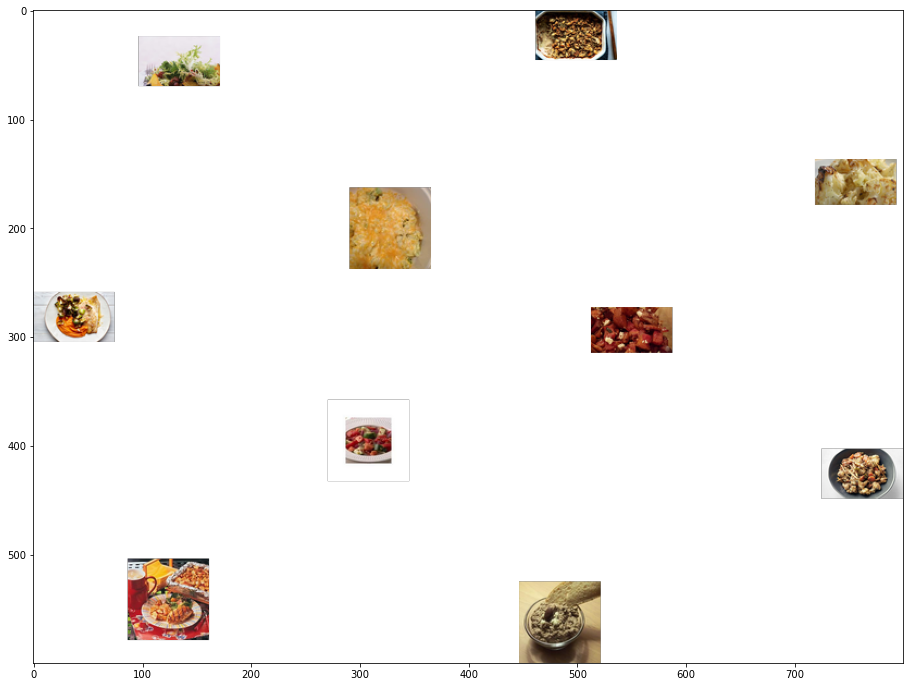

In [ ]:
width = 800
height = 600
max_dim = 75

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)
full_image.save("/data/6-pics-cloud.png")

## Find recipes of top N closest images that we found

### Read the recipe csv which holds the labels and it's corresponding recipes

In [ ]:
import pandas as pd

In [ ]:
recipes = pd.read_csv("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\recipe_name_image_lookup.csv")

In [ ]:
recipes

,Unnamed: 0,ingredients,instructions,photo_url,title,recipe_name,category,directories_names
0,0,"['1/2 cup unsalted butter, chilled and cubed',...",['Preheat oven to 400 degrees F (205 degrees C...,http://images.media-allrecipes.com/userphotos/...,"Basil, Roasted Peppers and Monterey Jack Cornb...","basil, roasted peppers monterey jack cornbread","['roasted', 'chicken']",roasted_chicken
1,1,"['1/2 cup Parmesan cheese', '3/4 teaspoon grou...","['Combine parmesan cheese, pepper and garlic p...",http://images.media-allrecipes.com/userphotos/...,Crispy Cheese Twists,crispy cheese twists,"['cheese', 'baked', 'macaroni', 'cheese']",cheese_baked_macaroni_cheese
2,2,"['2 cups hot water', '1/2 cup margarine', '1/3...",['Melt margarine in hot water. Add sugar and s...,http://images.media-allrecipes.com/userphotos/...,Mom's Yeast Rolls,mom's yeast rolls,['bread'],bread
3,3,"['1 1/2 cups white sugar', '1/2 cup vegetable ...",['Combine sugar and oil; beat well. Add eggs a...,http://images.media-allrecipes.com/userphotos/...,Sweet Potato Bread I,sweet potato bread i,['bread'],bread
4,4,"['1/4 cup butter', '1 teaspoon white sugar', '...",['Stir butter and 1 teaspoon sugar into the ho...,http://images.media-allrecipes.com/userphotos/...,Orange Buns,orange buns,"['cranberry', 'orange', 'cookies']",cranberry_orange_cookies
...,...,...,...,...,...,...,...,...
85981,13496,"['1 cup all-purpose flour', '2/3 cup unsweeten...",['Preheat the oven to 350°F. Into a bowl sift ...,brownie-pudding-cake-14408,Brownie Pudding Cake,brownie pudding cake,['cake'],cake
85982,13497,"['1 preserved lemon', '1 1/2 pound butternut s...","[""Preheat oven to 475°F.\nHalve lemons and sco...",israeli-couscous-with-roasted-butternut-squash...,Israeli Couscous with Roasted Butternut Squash...,israeli couscous roasted butternut squash pres...,"['roasted', 'chicken']",roasted_chicken
85983,13498,['Leftover katsuo bushi (dried bonito flakes) ...,"['If using katsuo bushi flakes from package, m...",rice-with-soy-glazed-bonito-flakes-and-sesame-...,Rice with Soy-Glazed Bonito Flakes and Sesame ...,rice soy-glazed bonito flakes sesame seeds,['rice'],rice
85984,13499,['1 stick (1/2 cup) plus 1 tablespoon unsalted...,['Melt 1 tablespoon butter in a 12-inch heavy ...,spanakopita-107344,Spanakopita,spanakopita,"['spinach', 'salad']",spinach_salad


In [24]:
# images[idx_closest[1]].split("\\")[8]
pred_labels = []
for id in idx_closest:
    pred_label = images[id].split("\\")[-2] # grabbing the label for the image, S.O to Shruti for this hack
    pred_labels.append(pred_label)

pred_labels

['pie_strawberry_pie',
 'coconut_chicken',
 'salad',
 'cheese_baked_macaroni_cheese',
 'cake']

In [25]:
# Dedupe categories/labels
pred_labels = list(set(pred_labels))

In [26]:
pred_labels

['cheese_baked_macaroni_cheese',
 'cake',
 'coconut_chicken',
 'salad',
 'pie_strawberry_pie']

In [30]:
recomended_recipies = pd.DataFrame(columns= ["directories_names","ingredients", "instructions"])

In [32]:
for label in pred_labels:
    row = recipes[recipes.directories_names == label][["directories_names","ingredients", "instructions"]].sample(n = 1)
    recomended_recipies = pd.concat([recomended_recipies, row])

In [36]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

C:\Users\Nilay\AppData\Local\Temp\ipykernel_23960\1855903363.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [38]:
recomended_recipies

,directories_names,ingredients,instructions
10562,cheese_baked_macaroni_cheese,"['2 (8 ounce) packages cream cheese', '1/2 cup white sugar', '2 eggs', '1 teaspoon vanilla extract', '1 teaspoon lemon juice', '1 1/8 cups graham cracker crumbs', '2 tablespoons white sugar', '1 pinch ground cinnamon', '1/4 cup butter', '1 (21 ounce) can cherry pie filling']","['Preheat oven to 350 degrees F (175 degrees C). Place cup cake liners into muffin tins.', 'To Make Filling: In a medium bowl, combine cream cheese and 1/2 cup sugar. Stir in eggs, vanilla and lemon juice. Mix thoroughly.', 'To Make Crust: Combine crumbs, 2 tablespoons sugar and cinnamon. Cut in butter until crust forms small crumbs. Put one spoonful of crust into each cup cake liner and pat it down. Spoon a layer of filling on top of crusts.', 'Bake in preheated oven for 30 minutes. When tarts are fresh from oven, spoon cherry pie filling over top of each. Let tarts chill in refrigerator for 30 minutes to an hour.']"
46584,cake,"['3 cups boiling water', '2 (3 ounce) packages JELL-O Raspberry Flavor Gelatin', '1 (12 ounce) package frozen red raspberries (do not thaw)', '1 (7.5 ounce) package round angel food cake, cut into 21 thin slices', '1 cup thawed COOL WHIP Whipped Topping']","['Add boiling water to gelatin mixes in medium bowl; stir 2 min. until completely dissolved. Add raspberries; stir until thawed. Pour into 9-inch round pan sprayed with cooking spray.', 'Arrange cake slices in concentric circles over gelatin, with slices overlapping as necessary to completely cover gelatin.', 'Refrigerate 3 hours or until gelatin is firm. Unmold onto plate; top with COOL WHIP.']"
2369,coconut_chicken,"['12 eggs', ""1 1/4 cups confectioners' sugar"", '20 fluid ounces brandy', '24 cups milk', '1 pinch ground nutmeg']","[""Separate the eggs. In a large bowl beat the egg whites until frothy. Whisk in 3/4 cup of the confectioners' sugar and beat until stiff peaks are formed."", ""Beat the egg yolks with the remaining 1/2 cup of confectioners' sugar and about 4 to 5 tablespoons of the brandy until light and lemon colored. Fold the egg whites into the egg yolks and refrigerate."", 'In a large stock pot heat the milk until hot but do not boil. Reduce heat and keep milk hot.', 'To each mug add 2 tablespoons brandy (or more to taste) and 1 large heaping tablespoon of egg mixture. Stir and fill mug with hot milk. Place another tablespoon of egg mixture on top and sprinkle with nutmeg.']"
64576,salad,"['2 cups shredded sharp Cheddar cheese', '1 1/4 cups mayonnaise', '4 cups torn iceberg lettuce', '2 large Roma (plum) tomatoes, or more to taste, chopped', '1 (6 ounce) can sliced black olives, drained', '1 (10 ounce) package frozen peas, thawed', '1 (4 ounce) can sliced water chestnuts, drained', '1/2 cup cooked crumbled bacon']","['Mix Cheddar cheese and mayonnaise together in a small bowl.', 'Pat lettuce into an even layer in the bottom of a large glass serving bowl. Layer tomatoes, black olives, peas, and water chestnuts, respectively, into the bowl. Spread Cheddar cheese mixture over the water chestnuts layer; top with bacon.', 'Cover bowl with plastic wrap and refrigerate until salad is chilled, at least 30 minutes.']"
65941,pie_strawberry_pie,"['1 prepared 9-inch single pie crust', '1 cup light corn syrup', '1 cup chopped pecans', '3 eggs, beaten', '1/4 cup butter, melted', '1/4 cup white sugar', '1 tablespoon orange juice', '1 tablespoon orange zest', '1/2 teaspoon salt']","['Preheat oven to 350 degrees F (175 degrees C). Press prepared pie crust into a pie plate.', 'Beat corn syrup, pecans, eggs, butter, sugar, orange juice, orange zest, and salt together in a bowl; pour into the pie crust.', 'Bake until pie filling is set in the center, about 45 minutes.']"


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
images_80_percent, images_20_percent =  train_test_split(images, test_size =.20, shuffle  = True)

In [ ]:
len(images_80_percent)

1399

In [ ]:
len(images_20_percent)

350

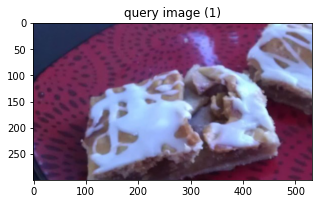

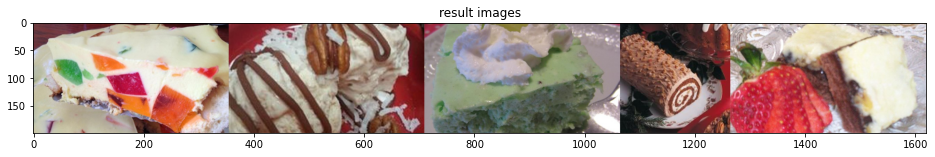

In [42]:
query_image, results_image, idx_closest, predicted_labels_of_indexes, percent_corect = test_single_image_accuracy(1, 5, True)

In [45]:
import pandas as pd
row = [query_image, results_image, idx_closest, predicted_labels_of_indexes, percent_corect]

get_recomended_recipes_for_closest_image(row)

,Categories,ingredients,instructions
82352,cheese_baked_macaroni_cheese,"['2 tablespoons olive oil', '2 large red onions, thinly sliced', '2 tablespoons Sherry wine vinegar', '1 teaspoon sugar', '8 ounces farfalle', '1 cup dry white wine', '1 cup low-salt chicken broth', '6 heirloom tomatoes, cored, chopped (about 5 cups)', '2 cups shredded cooked chicken (from 1/2 rotisserie chicken)', '1/2 cup thinly sliced basil leaves', '2 tablespoons chopped fresh marjoram', '3 cups baby spinach', '3 ounces soft fresh goat cheese', 'crumbled']","['Heat oil in heavy large skillet over mediumhigh heat. Add onions; sprinkle with salt and cook until beginning to brown, stirring often, about 8 minutes. Reduce heat to medium-low. Stir in vinegar and sugar; cook until onions are browned, stirring often, about 15 minutes. Transfer caramelized onions to bowl; reserve skillet.\nMeanwhile, cook pasta in large pot of boiling salted water until tender but still firm to bite, stirring occasionally. Drain.\nAdd wine to reserved skillet. Boil until reduced to 1/2 cup, 3 minutes. Add pasta, onions, broth, and next 4 ingredients. Season with salt and pepper. Stir over medium heat to warm through, about 3 minutes.\nDivide spinach among plates. Spoon pasta over spinach. Top with crumbled goat cheese.']"
53228,cake,"['1/4 cup butter', '3/4 cup light brown sugar', '1 tablespoon pineapple juice', '1 tablespoon dark rum (optional)', '1/2 small fresh pineapple - peeled, cored, and sliced', '1/2 cup butter', '1 1/2 cups all-purpose flour', '1/8 teaspoon ground cardamom', '1/2 teaspoon salt', '2 teaspoons baking powder', '1/2 cup white sugar', '1 egg', '1/2 cup cold milk']","['Preheat the oven to 400 degrees F (200 degrees C).', 'Melt 1/4 cup butter in a 12-inch cast iron skillet over medium-low heat. Stir in brown sugar, pineapple juice, and dark rum. Cook over medium-low heat until sugar is dissolved and mixture is bubbling, about 5 minutes.', 'Remove from heat and spread pineapple slices in a layer over the brown sugar mixture, completely covering the mixture. Set skillet aside.', 'Melt 1/2 cup butter in small skillet over low heat until the butter begins to brown and release a nutty fragrance, about 5 minutes. Watch carefully, butter burns easily. Remove from heat and let cool for 10 minutes.', 'Whisk together flour, cardamom, salt, baking powder, and white sugar in a large bowl. Whisk in egg and cold milk until just combined. Pour in melted butter and stir to mix thoroughly.', 'Pour batter over the pineapple slices in the skillet; spread evenly to cover.', 'Bake in preheated oven until the cake begins to bubble around the edges, the top is browned, and a toothpick inserted into the center comes out clean, about 30 to 35 minutes. Let cool in the skillet for 10 minutes.', 'Loosen the cake from the skillet by running a knife around the inside edge of the cake. Invert a large plate over the top of the skillet and flip over, releasing the cake to show the pineapple slices on top.']"
631,coconut_chicken,"['2 cups white sugar', '1 cup butter', '5 eggs', '2 cups all-purpose flour', '1 1/2 teaspoons baking powder', '1/2 cup milk', '3 1/2 ounces flaked coconut', '1 teaspoon coconut extract', '1 cup white sugar', '1/4 cup water', '1 teaspoon coconut extract', '1/2 cup chopped walnuts']","['Preheat oven to 350 degrees F (175 degrees C). Grease and flour a 10 inch tube pan.', 'In a large bowl, cream together 2 cups sugar and the butter. Fold in the eggs one at a time, fully incorporating each one before adding another.', 'In separate bowl, mix the flour, baking powder, milk, flaked coconut, and 1 teaspoon coconut extract. Beat into the creamed mixture. Pour the batter into the prepared pan.', 'Bake 1 hour in the preheated oven, or until a knife inserted in the center comes out clean. Cool on a wire rack for just a few minutes, then place on cake platter.', 'To make the glaze, mix together in a small saucepan 1 cup sugar, water, 1 teaspoon coconut extract, and walnuts. Boil